In [ ]:
!pip install kaggle --upgrade
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
#!mkdir datase
!cd dataset
!kaggle competitions download -c carvana-image-masking-challenge

In [ ]:
pip install --upgrade torch

In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge
!unzip carvana-image-masking-challenge.zip -d /content/dataset/
!rm carvana-image-masking-challenge.zip

In [ ]:
!mkdir /content/dataset/train

In [ ]:
!unzip /content/dataset/train_hq.zip -d /content/dataset/train/
!unzip /content/dataset/train_masks.zip -d /content/dataset/train/

In [ ]:
!rm -r /content/augData/*
!rm -r /content/dataset

In [ ]:
!pip install opencv-python

# DataManip

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
!mkdir dataset
!unrar x /content/drive/MyDrive/glassSeg/LASTFOLDER.rar  /content/dataset
!mv /content/dataset/content/new_images /content/dataset/content/images
!mv /content/dataset/content/new_mask /content/dataset/content/masks

path="/content/dataset/content/masks"
for folder_name in os.listdir(path):
    folder=os.path.join(path, folder_name)
    os.rename(folder,folder.replace("image_with_mask0",""))
path="/content/dataset/content/images"
for folder_name in os.listdir(path):
    folder=os.path.join(path, folder_name)
    os.rename(folder,folder.replace("image_with_mask",""))

In [ ]:
!zip -r data.zip '/content/dataset/content'

In [ ]:
from os.path import splitext, isfile, join
from pathlib import Path
from os import listdir
import random as rd
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from google.colab.patches import cv2_imshow
dir_img='/content/dataset/content/images'
dir_mask='/content/dataset/content/masks'

In [ ]:
idx =[splitext(file)[0] for file in listdir(dir_img) if isfile(join(dir_mask, file)) and not file.startswith('.')]

Preprocess Masks

In [ ]:
import cv2
from PIL import Image
progress_bar = tqdm(total=len(idx), desc="Processing images")
for id in idx :
  mask=cv2.imread(join(dir_mask,id+'.png'))
  mask=cv2.medianBlur(mask, 3)
  cv2.imwrite(join(dir_mask,id+'.png'),mask)
  msk =Image.open(join(dir_mask,id+'.png'))
  #img=Image.open(join(dir_img,id+'.png'))
  #img = np.asarray(img)
  msk = np.asarray(msk)
  msk[msk==125]=255





  msk = Image.fromarray(msk)
  msk=msk.resize((640,360),resample=Image.NEAREST)
  msk.save(join(dir_mask,id+'.png'))


  progress_bar.update(1)



#for i in np.unique(np.array(msk)):
  #print(i,np.countnonzero(msk == i),sep=":")


Processing images: 100%|██████████| 1844/1844 [02:33<00:00, 13.96it/s]

# UnetParts

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        torch.nn.init.kaiming_normal_(self.double_conv[0].weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.double_conv[3].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Unet Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Utils

load data

In [ ]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        print(f'Creating dataset with {len(self.ids)} examples')
        print('Scanning mask files to determine unique values')

        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        #self.mask_values=[0, 125, 255]
        logging.info(f'Unique mask values: {self.mask_values}')
        print(self.mask_values)




    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = load_image(mask_file[0])
        mask=mask.resize((640,360),resample=Image.NEAREST)
        mask = np.asarray(mask)

        mask = Image.fromarray(mask)
        img = load_image(img_file[0])
        img=img.resize((640,360),resample=Image.BILINEAR)
        img=img.convert('RGB')


        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)
        mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, images_dir, mask_dir, scale=1):
        super().__init__(images_dir, mask_dir, scale, mask_suffix='_mask')

dice_score

In [ ]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff

    return 1 - fn(input, target, reduce_batch_first=True)
    """class_weight=2.0
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    dice_coefficient = fn(input, target, reduce_batch_first=True)
    specific_class = 1  # Replace 0 with the index of your specific class

    # Create a weight tensor with higher weight for the specific class
    weight = torch.ones_like(target)
    weight[target == specific_class] = class_weight

    # Apply the weight to the dice coefficient
    weighted_dice_coefficient = dice_coefficient * weight

    # Calculate the loss by subtracting the weighted dice coefficient from 1
    loss = 1 - weighted_dice_coefficient.mean()

    return abs(loss)"""









cross-entropy

In [ ]:
import torch
from torch import Tensor


def cross_entropy_loss(input: Tensor, target: Tensor):
    # Cross-entropy loss between predicted and ground truth segmentation masks
    assert input.size() == target.size()

    # Flatten inputs to 2D tensors (batch_size x num_classes, height x width)
    input = input.reshape(-1, input.size(-1))
    target = target.reshape(-1)

    # Compute cross-entropy loss
    loss = torch.nn.functional.cross_entropy(input, target)

    return loss
def iou_score(input: Tensor, target: Tensor):
    # Intersection over Union (IoU) score between predicted and ground truth segmentation masks
    assert input.size() == target.size()

    # Flatten inputs to 2D tensors (batch_size x num_classes, height x width)
    input = input.view(-1, input.size(-1))
    target = target.view(-1)

    # Compute true positive, false positive, and false negative
    tp = (input * target).sum(dim=0)
    fp = (input * (1 - target)).sum(dim=0)
    fn = ((1 - input) * target).sum(dim=0)

    # Compute IoU for each class
    iou = tp / (tp + fp + fn + 1e-6)

    # Compute mean IoU across all classes
    miou = iou.mean()

    return miou

evaluate

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm



@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score=0


    # iterate over the validation set
    #with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score +=multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)
                #iou_score +=iou_score(mask_pred[:, 1:],mask_true[:, 1:])
    net.train()
    return dice_score / max(num_val_batches, 1)
    #return iou_score/max(num_val_batches, 1)

# Train

In [ ]:
!pip install wandb

In [ ]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb



In [ ]:
!mkdir /content/checkpoints

mkdir: cannot create directory ‘/content/checkpoints’: File exists


In [ ]:
#all CUDA errors are reported synchronously
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:

dir_checkpoint = Path('./checkpoints/')
import argparse


def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 4,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    # 1. Create dataset
    try:
        dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-netGlass',entity='firaslassoied8', resume='allow', anonymous='never')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                     masks_pred = model(images)
                     if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(),multiclass=False)
                     else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),multiclass=True
                        )
                       # loss += cross_entropy_loss(masks_pred, true_masks)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if value.requires_grad==True :
                               if not (torch.isinf(value.grad) | torch.isnan(value)).any():
                                 histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')
        if epoch==epochs:
          artifact = wandb.Artifact("model-checkpoint", type="model")
          artifact.add_file(str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
          wandb.log_artifact(artifact)


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=2, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device=torch.device('cpu')
    logging.info(f'Using device {device}')


    # n_channels=3 for RGB images
    # n_classes is the number of probabilities  to get per pixel
    model = UNet(n_channels=3, n_classes=2, bilinear=args.bilinear)

    #model.load_state_dict(torch.load('/content/artifacts/model-checkpoint:v5/checkpoint_epoch5.pth'),strict=False)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/glassSeg/checkpoint_epoch4.pth'),strict=False)
    """ model.outc = (OutConv(64, 3))
    model.n_classes=3
    #model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)'''
    for name ,value in model.named_parameters():
      if (not name.startswith('up4'))and (not name.startswith('outc'))and (not name.startswith('up3'))and (not name.startswith('up2')):
          value.requires_grad = False"""
    model = model.to(memory_format=torch.channels_last)
    model=model.to(device)

    logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')


    train_model(
            model=model,
            epochs=10,
            batch_size=8,
            learning_rate=1e-5,
            device=device,
            img_scale=1,
            val_percent=args.val / 100,
            amp=args.amp
        )


Creating dataset with 2594 examples
Scanning mask files to determine unique values


  0%|          | 0/2594 [00:00<?, ?it/s]

Creating dataset with 2594 examples
Scanning mask files to determine unique values



100%|██████████| 2594/2594 [00:18<00:00, 142.81it/s]


[0, 255]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/10:  20%|█▉        | 464/2335 [01:58<07:32,  4.13img/s, loss (batch)=0.258]

Validation round:   0%|          | 0/32 [00:00<?, ?batch/s]

Validation round:   3%|▎         | 1/32 [00:02<01:02,  2.01s/batch]

Validation round:   6%|▋         | 2/32 [00:02<00:39,  1.30s/batch]

Validation round:   9%|▉         | 3/32 [00:03<00:30,  1.06s/batch]

Validation round:  12%|█▎        | 4/32 [00:04<00:25,  1.09batch/s]

Validation round:  16%|█▌        | 5/32 [00:05<00:22,  1.18batch/s]

Validation round:  19%|█▉        | 6/32 [00:05<00:20,  1.26batch/s]

Validation round:  22%|██▏       | 7/32 [00:06<00:18,  1.32batch/s]

Validation round:  25%|██▌       | 8/32 [00:07<00:17,  1.37batch/s]

Validation round:  28%|██▊       | 9/32 [00:07<00:16,  1.40batch/s]

Validation round:  31%|███▏      | 10/32 [00:08<00:15,  1.42batch/s]

Validation round:  34%|███▍      | 11/32 [00:09<00:14,  1.43batch/s]

Validation round:  38%|███▊      | 12/32 [00:09<00:13,  1.44batch/s]

Validation round:  41%|

# Testing

In [ ]:
model = UNet(n_channels=3, n_classes=2, bilinear=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/glassSeg/checkpoint_epoch4.pth'),strict=False)
for name ,value in model.named_parameters():
  if name.startswith('outc')or name.startswith('up4'):
   print (name,value.data.shape)
print(model.n_classes)
print("####################tuning#############################")
model.outc = (OutConv(64, 3))
model1 = UNet(n_channels=3, n_classes=3, bilinear=False)
for name ,value in model1.named_parameters():

   print (name,value.data.shape)
'''model.n_classes=3
print(model.n_classes) '''

In [ ]:

total_params = 0
for name ,value in model.named_parameters():
  if not value.requires_grad:
    continue
  param_params = torch.prod(torch.tensor(value.size()))
  print (name,value.data.shape,param_params)






inc.double_conv.0.weight torch.Size([64, 3, 3, 3]) tensor(1728)
inc.double_conv.1.weight torch.Size([64]) tensor(64)
inc.double_conv.1.bias torch.Size([64]) tensor(64)
inc.double_conv.3.weight torch.Size([64, 64, 3, 3]) tensor(36864)
inc.double_conv.4.weight torch.Size([64]) tensor(64)
inc.double_conv.4.bias torch.Size([64]) tensor(64)
down1.maxpool_conv.1.double_conv.0.weight torch.Size([128, 64, 3, 3]) tensor(73728)
down1.maxpool_conv.1.double_conv.1.weight torch.Size([128]) tensor(128)
down1.maxpool_conv.1.double_conv.1.bias torch.Size([128]) tensor(128)
down1.maxpool_conv.1.double_conv.3.weight torch.Size([128, 128, 3, 3]) tensor(147456)
down1.maxpool_conv.1.double_conv.4.weight torch.Size([128]) tensor(128)
down1.maxpool_conv.1.double_conv.4.bias torch.Size([128]) tensor(128)
down2.maxpool_conv.1.double_conv.0.weight torch.Size([256, 128, 3, 3]) tensor(294912)
down2.maxpool_conv.1.double_conv.1.weight torch.Size([256]) tensor(256)
down2.maxpool_conv.1.double_conv.1.bias torch.Size

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gdown

In [ ]:
gdown.download("https://renderpeople.com/sample/free/renderpeople_free_rigged_people_MAX.zip",output="/content/3dmodels/")

In [ ]:
!unzip /content/rp_carla_rigged_001_MAX.zip

In [ ]:
!unzip --help


In [ ]:
!git clone https://github.com/shunsukesaito/PIFu.git


In [ ]:
import gdown
gdown.download("https://renderpeople.com/sample/free/rp_dennis_posed_004_OBJ.zip")

Downloading...
From: https://renderpeople.com/sample/free/rp_dennis_posed_004_OBJ.zip
To: /content/rp_dennis_posed_004_OBJ.zip
100%|██████████| 133M/133M [00:00<00:00, 363MB/s]


'rp_dennis_posed_004_OBJ.zip'

In [ ]:
!unzip /content/rp_dennis_posed_004_OBJ.zip


In [ ]:
!pip install -r /content/PIFu/requirements.txt

In [ ]:
!python -m PIFu.apps.prt_util -i /content/rp_dennis_posed_004_100k.obj

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('firaslassoied8/U-netGlass/model-checkpoint:v10', type='model')
artifact_dir = artifact.download()

epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▃▄▃▂▂▃▆▃▄▃▂▃▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
validation Dice,▁▃▃▅▄▅▅▄▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,7
learning rate,1e-05
step,2044
train loss,0.02185
validation Dice,0.95374


wandb: Downloading large artifact model-checkpoint:v10, 118.49MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import splitext
from os import listdir

#import params

input_size = (640,360)
batch_size = 1
orig_width = 640
orig_height = 360
threshold = 125
#model = params.model_factory()

#df_test = pd.read_csv('input/sample_submission.csv')
ids_test = [splitext(file)[0] for file in listdir('/content/testData/testGlasses') ]

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

#model.load_weights(filepath='weights/best_weights.hdf5')
import wandb
run = wandb.init()
artifact = run.use_artifact('firaslassoied8/U-netGlass/model-checkpoint:v10', type='model')
artifact_dir = artifact.download()


print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
for start in tqdm(range(0, len(ids_test), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch:
        img = cv2.imread('input/test/{}.jpg'.format(id))
        #img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('submit/submission.csv.gz', index=False, compression='gzip')

wandb: Downloading large artifact model-checkpoint:v10, 118.49MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Predicting on 8 samples with batch_size = 1...


  0%|          | 0/8 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
from PIL import Image
from tqdm import tqdm
from os.path import splitext
import os

files = os.listdir('/content/testData/testGlasses')
n = len(files)
progress_bar = tqdm(total=n, desc="Processing images")
for p in os.listdir('/content/testData/testGlasses'):
    path = os.path.join('/content/testData/testGlasses', p)
    im=Image.open(path)
    im=im.convert("RGB")
    im.save(os.path.join('/content/testData/testGlasses', splitext(p)[0]+".jpg"))
    if im.size!=(640,360):
       im=im.resize((640,360),resample=Image.BILINEAR)
       print(splitext(p)[0]+"jpg")
       im.save(os.path.join('/content/testData/testGlasses', splitext(p)[0]+".jpg"))
    progress_bar.update(1)


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
!mkdir testData
!unzip  /content/drive/MyDrive/glassSeg/testGlasses.zip  -d /content/testData

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/glassSeg/testGlasses.zip
  inflating: /content/testData/testGlasses/download.jfif  
  inflating: /content/testData/testGlasses/images (1).jfif  
  inflating: /content/testData/testGlasses/images (2).jfif  
  inflating: /content/testData/testGlasses/images (3).jfif  
  inflating: /content/testData/testGlasses/images (4).jfif  
  inflating: /content/testData/testGlasses/images (5).jfif  
  inflating: /content/testData/testGlasses/images (6).jfif  
  inflating: /content/testData/testGlasses/images.jfif  


In [ ]:
print(splitext("/content/testData/testGlasses/images (1).jfif")[0]+"j.pg")

In [ ]:
!rm -r /content/testData/testGlasses/.ipynb_checkpoints

###########images (1)############


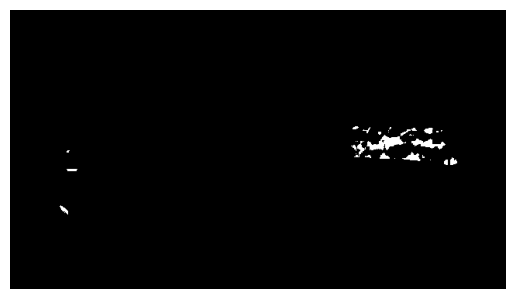

###########images (4)############


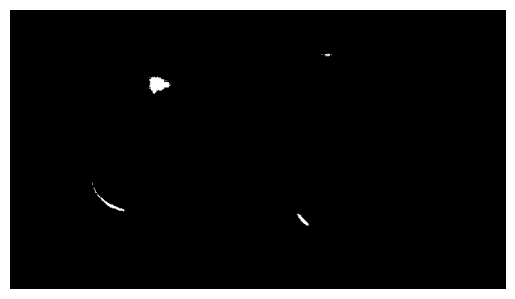

###########IMG_20230621_133840############


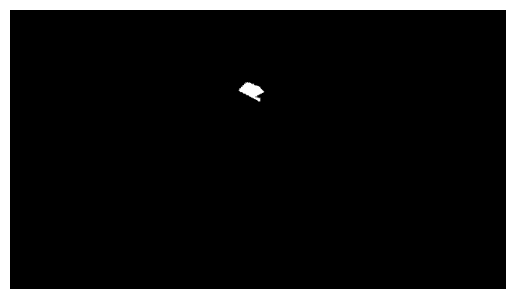

###########images############


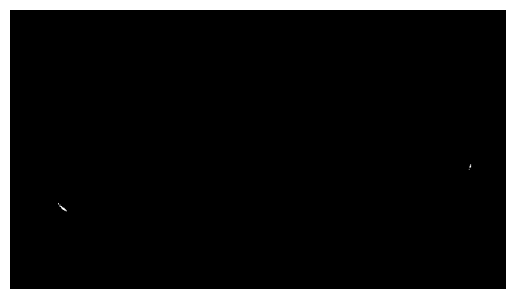

###########IMG_20230621_132628############


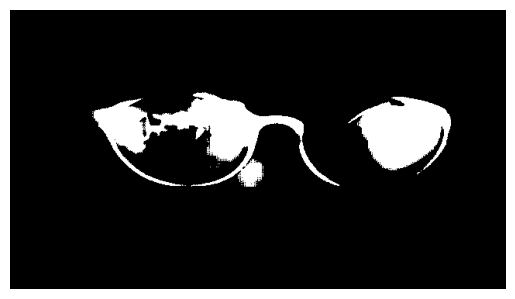

###########images (3)############


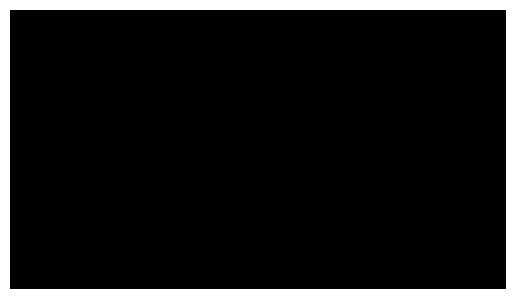

###########images (5)############


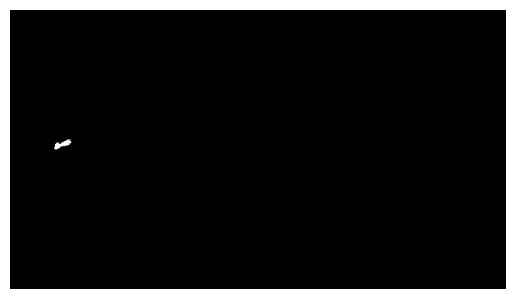

###########images (6)############


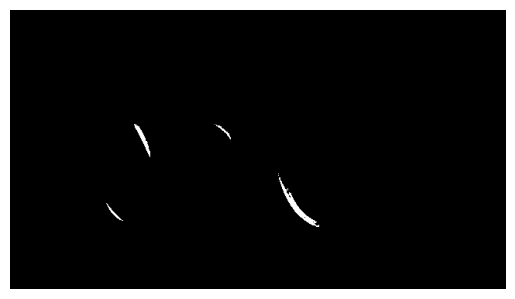

###########images (2)############


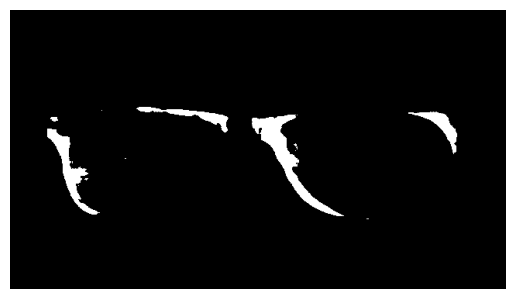

In [ ]:
import torch
from PIL import Image
from os import listdir
from os.path import splitext ,join
import numpy as np
import matplotlib.pyplot as plt


model = UNet(n_channels=3, n_classes=2, bilinear=False)
model.load_state_dict(torch.load('/content/checkpoints/checkpoint_epoch6.pth'),strict=False)
ids_test = [splitext(file)[0] for file in listdir('/content/testData/testGlasses') ]
threshold = 0.5
for id in ids_test:
  img=Image.open(join('/content/testData/testGlasses',id+'.jpg'))
  img=np.asarray(img)
  if img.ndim == 2:
    img = img[np.newaxis, ...]
  else:
    img = img.transpose((2, 0, 1))

  if (img > 1).any():
    img = img / 255.0

  tensor=torch.as_tensor(img.copy()).float().contiguous()
  input_tensor = tensor.unsqueeze(0)
  model.eval()
  with torch.no_grad():
    output = model(input_tensor)
    print('###########{}############'.format(id))
    threshold = 0.1
    #binary_mask = (output > threshold).squeeze(output, axis=3).numpy()
    binary_mask=output.argmax(dim=1).float().cpu()

    binary_mask = (binary_mask > threshold).squeeze().numpy()


    img=binary_mask*255
    plt.imshow(img,cmap='gray')
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()






In [ ]:
!mv /content/drive/MyDrive/glassSeg/IMG_20230621_133840.jpg /content/testData/testGlasses/

# DataAugmenation

Reduce Dimension of masks

In [ ]:
from tqdm import tqdm
from os import listdir
import random
from os.path import splitext,join,isfile
from PIL import Image
#progress_bar = tqdm(total=len(rand_idx), desc="Processing images")
idx =[splitext(file)[0] for file in listdir('/content/dataset/content/images') if isfile(join('/content/dataset/content/masks', file)) and not file.startswith('.')]

for id in tqdm(idx,desc='reduce dimension'):

   mask=Image.open(join('/content/dataset/content/masks',id+'.png'))
   mask=mask.convert('L')
   mask.save(join('/content/dataset/content/masks',id+'.png'))

reduce dimension: 100%|██████████| 1844/1844 [00:48<00:00, 38.29it/s]


Recise masks to (640,360)

In [ ]:
from tqdm import tqdm
from os import listdir
import random
from os.path import splitext,join,isfile
from PIL import Image
#progress_bar = tqdm(total=len(rand_idx), desc="Processing images")
idx =[splitext(file)[0] for file in listdir('/content/dataset/content/images') if isfile(join('/content/dataset/content/masks', file)) and not file.startswith('.')]

for id in tqdm(idx,desc='resize Masks'):

   mask=Image.open(join('/content/dataset/content/masks',id+'.png'))
   mask=mask.resize((640,360),resample=Image.NEAREST)

   mask.save(join('/content/dataset/content/masks',id+'.png'))


resize Masks: 100%|██████████| 1844/1844 [00:14<00:00, 129.65it/s]


Data Aug Function

In [ ]:
import cv2
import numpy as np

# Define the data augmentation transformations
def augment_data(image, mask):
    # Random horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Random vertical flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    # Random rotation
    angle = np.random.randint(-15, 15)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    mask = cv2.warpAffine(mask, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT,borderValue=(0,0,0))


    # Random color jitter
    brightness = np.random.uniform(0.9, 1.1)
    contrast = np.random.uniform(0.9, 1.1)
    saturation = np.random.uniform(0.9, 1.1)
    hue = np.random.uniform(-0.1, 0.1)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.multiply(image[:, :, 2], brightness)
    image[:, :, 1] = cv2.multiply(image[:, :, 1], contrast)
    image[:, :, 0] = cv2.multiply(image[:, :, 0], saturation)
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Random resized crop
    scale = np.random.uniform(0.98, 1.0)
    crop_size = (355,630)
    scaled_height = int(image.shape[0] * 1.0)
    scaled_width = int(image.shape[1] * 1.0)
    #image = cv2.resize(image, (scaled_width, scaled_height))
    #mask = cv2.resize(mask, (scaled_width, scaled_height))
    top = np.random.randint(0, scaled_height - crop_size[0])
    left = np.random.randint(0, scaled_width - crop_size[1])
    image = image[top:top+crop_size[0], left:left+crop_size[1]]
    mask = mask[top:top+crop_size[0], left:left+crop_size[1]]

    return image, mask

Select Random Sample

In [ ]:
import random
ids =[splitext(file)[0] for file in listdir('/content/dataset/content/images') if isfile(join('/content/dataset/content/masks', file)) and not file.startswith('.')]
rand_idx=random.sample(ids,250)

In [ ]:
!mkdir /content/augData
!mkdir /content/augData/masks
!mkdir /content/augData/images

In [ ]:
from tqdm import tqdm
from os import listdir

from os.path import splitext,join,isfile
#progress_bar = tqdm(total=len(rand_idx), desc="Processing images")
AugmentedNum=3
for id in tqdm(rand_idx,desc='Data Augmentation'):
   image=cv2.imread(join('/content/dataset/content/images',id+'.png'))
   mask=cv2.imread(join('/content/dataset/content/masks',id+'.png'))
   newids=[id+'new'+str(j) for j in range(AugmentedNum)]
   for newid in newids:
    newimage, newmask=augment_data(image,mask)
    cv2.imwrite(join('/content/augData/images',newid+'.png'),newimage)
    cv2.imwrite(join('/content/augData/masks',newid+'.png'),newmask)


Data Augmentation: 100%|██████████| 250/250 [00:25<00:00,  9.64it/s]


In [ ]:
import cv2
from PIL import Image
dir_Augmask='/content/augData/masks'
dir_Augimg='/content/augData/images'
idx=idx =[splitext(file)[0] for file in listdir(dir_Augimg) if isfile(join(dir_Augmask, file)) and not file.startswith('.')]
progress_bar = tqdm(total=len(idx), desc="Processing images")
for id in idx:
  mask=cv2.imread(join(dir_Augmask,id+'.png'))
  mask=cv2.medianBlur(mask, 3)
  cv2.imwrite(join(dir_Augmask,id+'.png'),mask)
  msk =Image.open(join(dir_Augmask,id+'.png'))
  #img=Image.open(join(dir_img,id+'.png'))
  #img = np.asarray(img)
  msk = np.asarray(msk)
  msk[msk<=125]=0
  msk[msk>125]=255

  msk = Image.fromarray(msk)
  msk.convert('L')
  msk=msk.resize((640,360),resample=Image.NEAREST)
  msk.save(join(dir_Augmask,id+'.png'))


  progress_bar.update(1)

In [ ]:
!rm -r /content/augData/images/*
!rm -r /content/augData/masks/*

In [ ]:
import cv2
image=cv2.imread('/content/dataset/content/masks/1004new0.png')
mask=cv2.imread('/content/dataset/content/masks/1004.png')
print(image.shape)

cv2_imshow(mask)
cv2_imshow(image)
#cv2_imshow(msk)
#cv2_imshow(img)
print(image.shape)

In [ ]:
!mv /content/augData/images/* /content/dataset/content/images/
!mv /content/augData/masks/* /content/dataset/content/masks/

In [ ]:
from PIL  import Image
import numpy as np
image=Image.open('/content/augData/masks/1004new0.png')
#image=image.resize(640,360,Image.BICUBIC)
for i in np.unique(np.array(image)):
  print(i,np.count_nonzero(np.array(image) == i),sep=":")

0:648396
255:42804


In [ ]:
!rm -r /content/dataset

In [ ]:
image=Image.open('/content/augData/masks/1004new0.png')
image1=Image.open('/content/dataset/content/masks/1004.png')
img=np.asarray(image)
img1=np.asarray(image1)
print(img.ndim)
print(img1.ndim)


3
2


In [ ]:
mask=cv2.imread('/content/dataset/content/images/1.png')
image=cv2.imread('/content/dataset/content/masks/1.png')

In [ ]:
angle = np.random.randint(-15, 15)
rows, cols = image.shape[:2]
M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
mask = cv2.warpAffine(mask, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT,borderValue=(0,0,0))

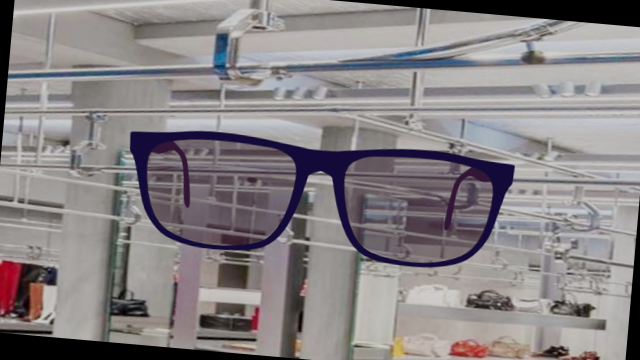

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(mask)